In [6]:
from preamble import *
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.datasets import load_breast_cancer
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=3)
Xm_train, Xm_test, ym_train, ym_test = train_test_split(
    Xm, ym, stratify=ym, random_state=42)

cancer = load_breast_cancer()
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

### 배깅(Bagging)
* 배깅을 사용하여 cancer 데이터셋에 로지스틱 회귀 모델을 100개 훈련하여 앙상블해보겠습니다.

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
bagging = BaggingClassifier(LogisticRegression(), n_estimators=100, oob_score=True, n_jobs=-1, random_state=42)
bagging.fit(Xc_train, yc_train)

BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100,
                  n_jobs=-1, oob_score=True, random_state=42)

In [11]:
print("훈련 세트 정확도: {:.3f}".format(bagging.score(Xc_train, yc_train)))
print("테스트 세트 정확도: {:.3f}".format(bagging.score(Xc_test, yc_test)))
print("OOB 샘플의 정확도: {:.3f}".format(bagging.oob_score_))

훈련 세트 정확도: 0.953
테스트 세트 정확도: 0.951
OOB 샘플의 정확도: 0.946


* 결정 트리로 배깅을 수행하는 것보다 랜덤 포레스트를 사용하는 것이 편리하지만 여기서는 직접 결정 트리에 배깅을 적용해보겠습니다.

In [12]:
from sklearn.tree import DecisionTreeClassifier
bagging = BaggingClassifier(DecisionTreeClassifier(), n_estimators=5, n_jobs=-1, random_state=42)
bagging.fit(Xm_train, ym_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=5,
                  n_jobs=-1, random_state=42)

* 랜덤 포레스트에서처럼 이 배경 분류기에 있는 결정 트리의 결정 경계를 시각화해보겠습니다.

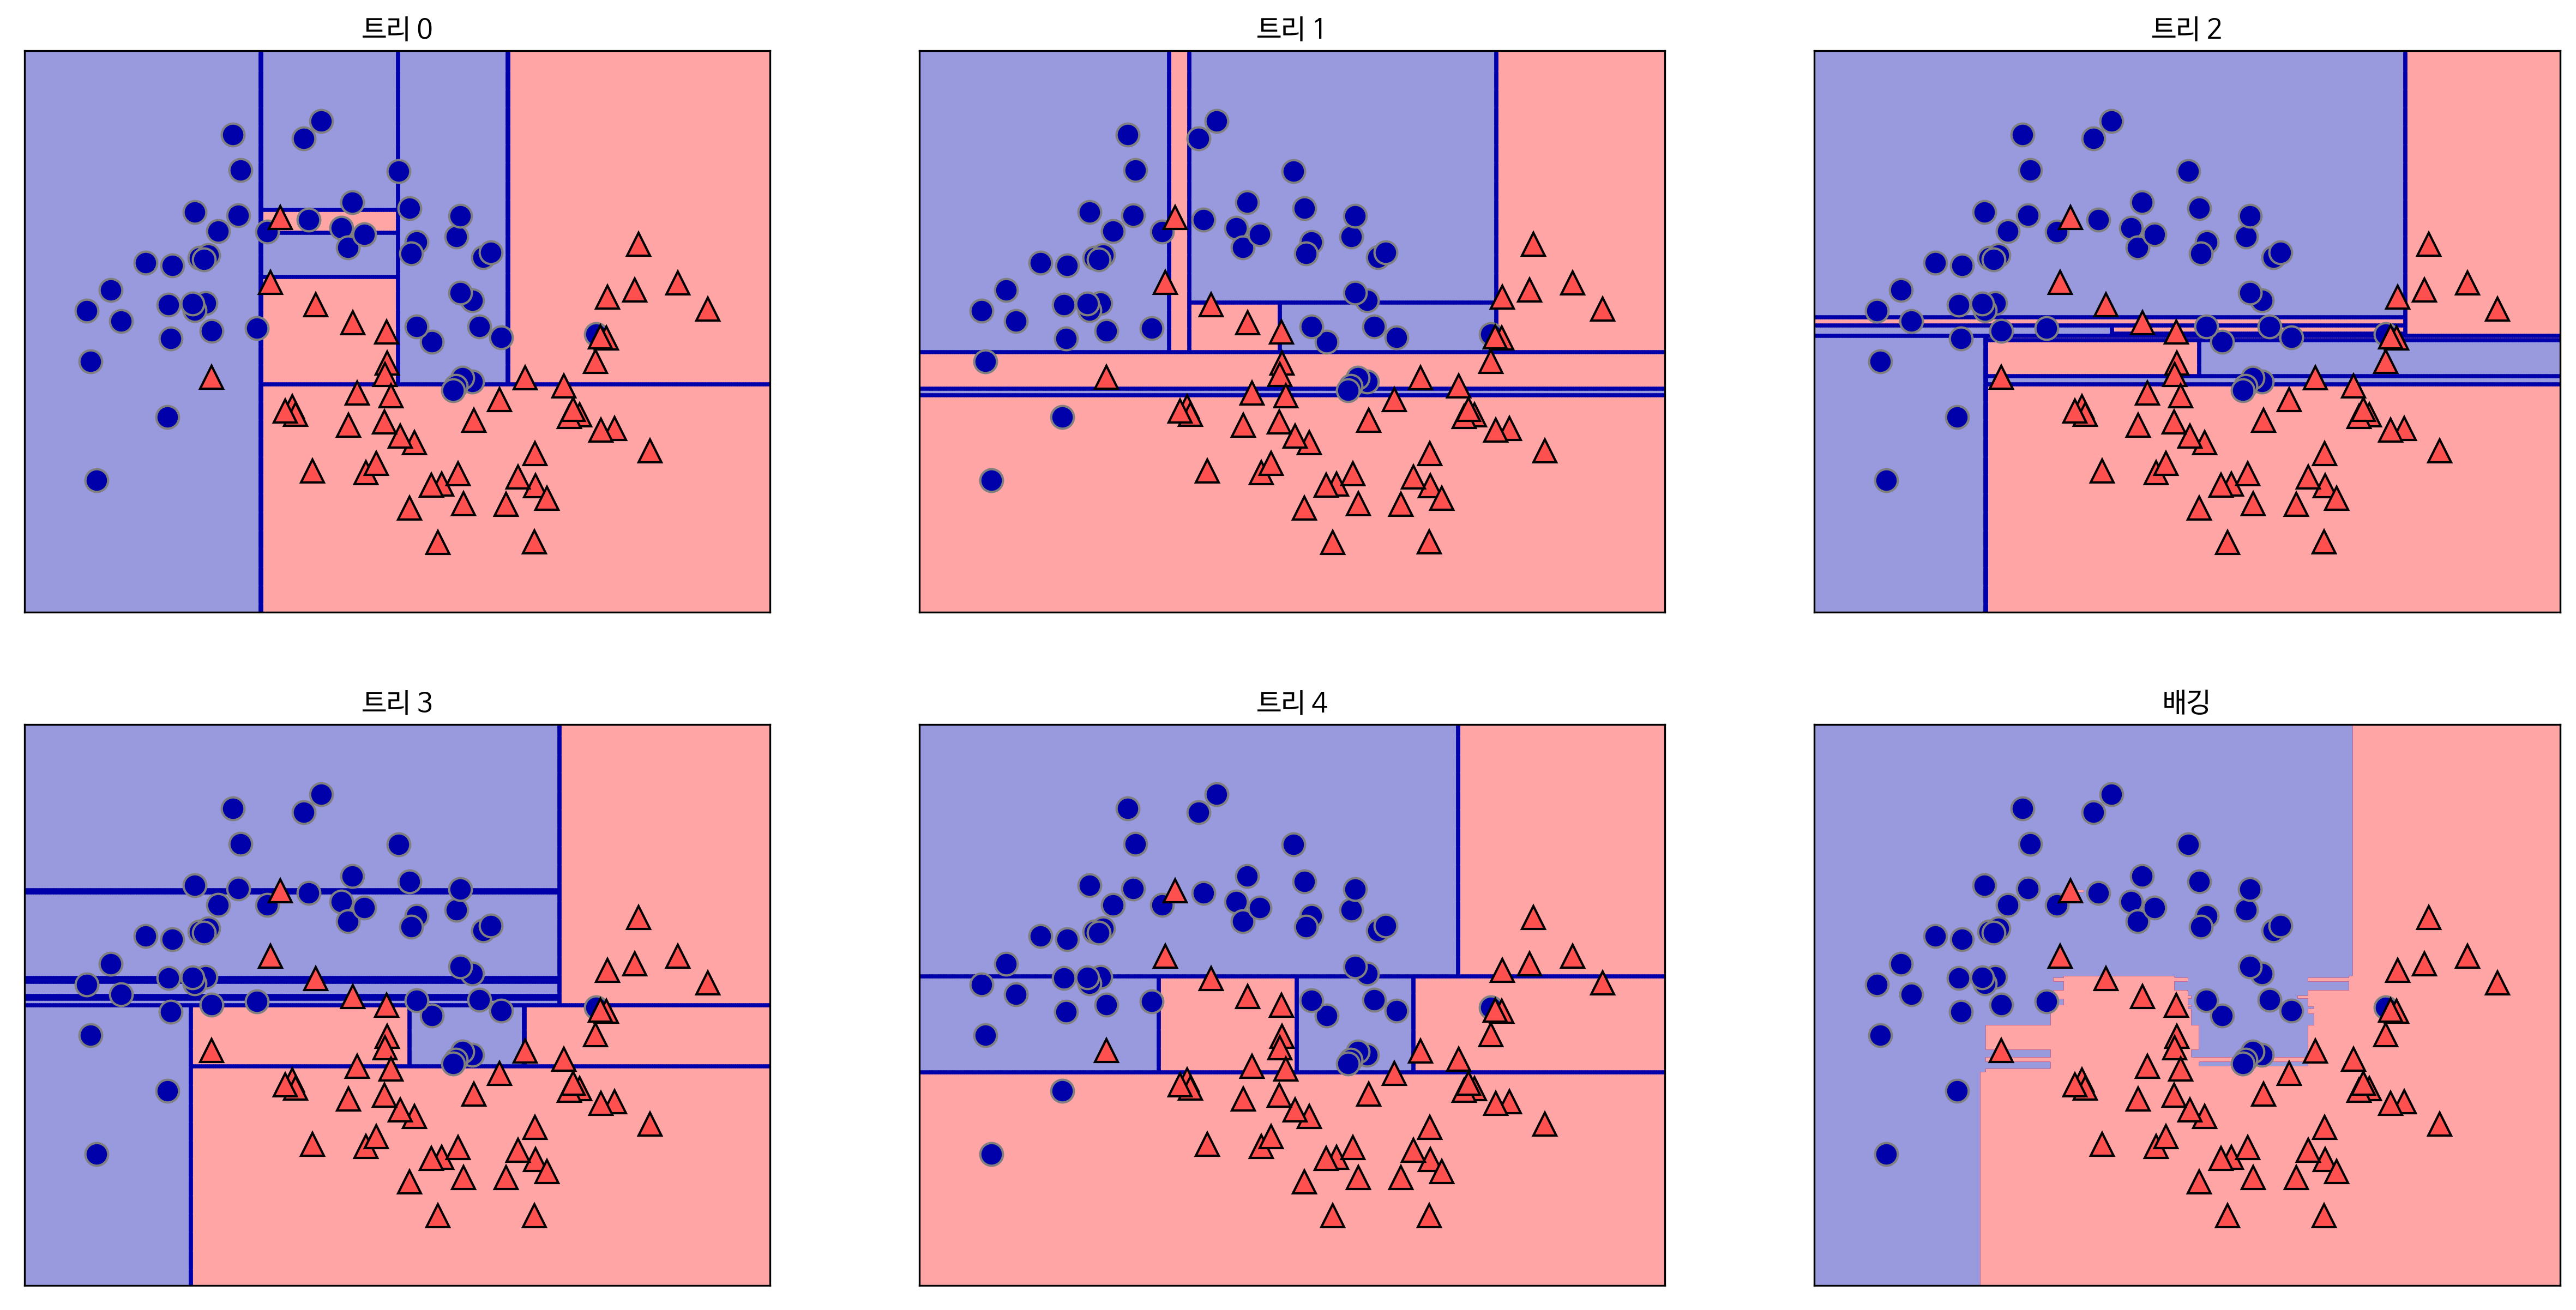

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), bagging.estimators_)):
    ax.set_title("트리 {}".format(i))
    mglearn.plots.plot_tree_partition(Xm, ym, tree, ax=ax)
mglearn.plots.plot_2d_separator(bagging, Xm, fill=True, ax=axes[-1, -1], alpha=.4)
axes[-1, -1].set_title("배깅")
mglearn.discrete_scatter(Xm[:, 0], Xm[:, 1], ym)
plt.show()

In [14]:
bagging = BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, oob_score=True, n_jobs=-1, random_state=42)
bagging.fit(Xc_train, yc_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100,
                  n_jobs=-1, oob_score=True, random_state=42)

In [16]:
print("훈련 세트 정확도: {:.3f}".format(bagging.score(Xc_train, yc_train)))
print("테스트 세트 정확도: {:.3f}".format(bagging.score(Xc_test, yc_test)))
print("OOB 샘플의 정확도: {:.3f}".format(bagging.oob_score_))

훈련 세트 정확도: 1.000
테스트 세트 정확도: 0.965
OOB 샘플의 정확도: 0.948


### 엑스트라 트리(Extra Trees)

In [19]:
from sklearn.ensemble import ExtraTreesClassifier
xtree = ExtraTreesClassifier(n_estimators=5, n_jobs=-1, random_state=0)
xtree.fit(Xm_train, ym_train)

ExtraTreesClassifier(n_estimators=5, n_jobs=-1, random_state=0)

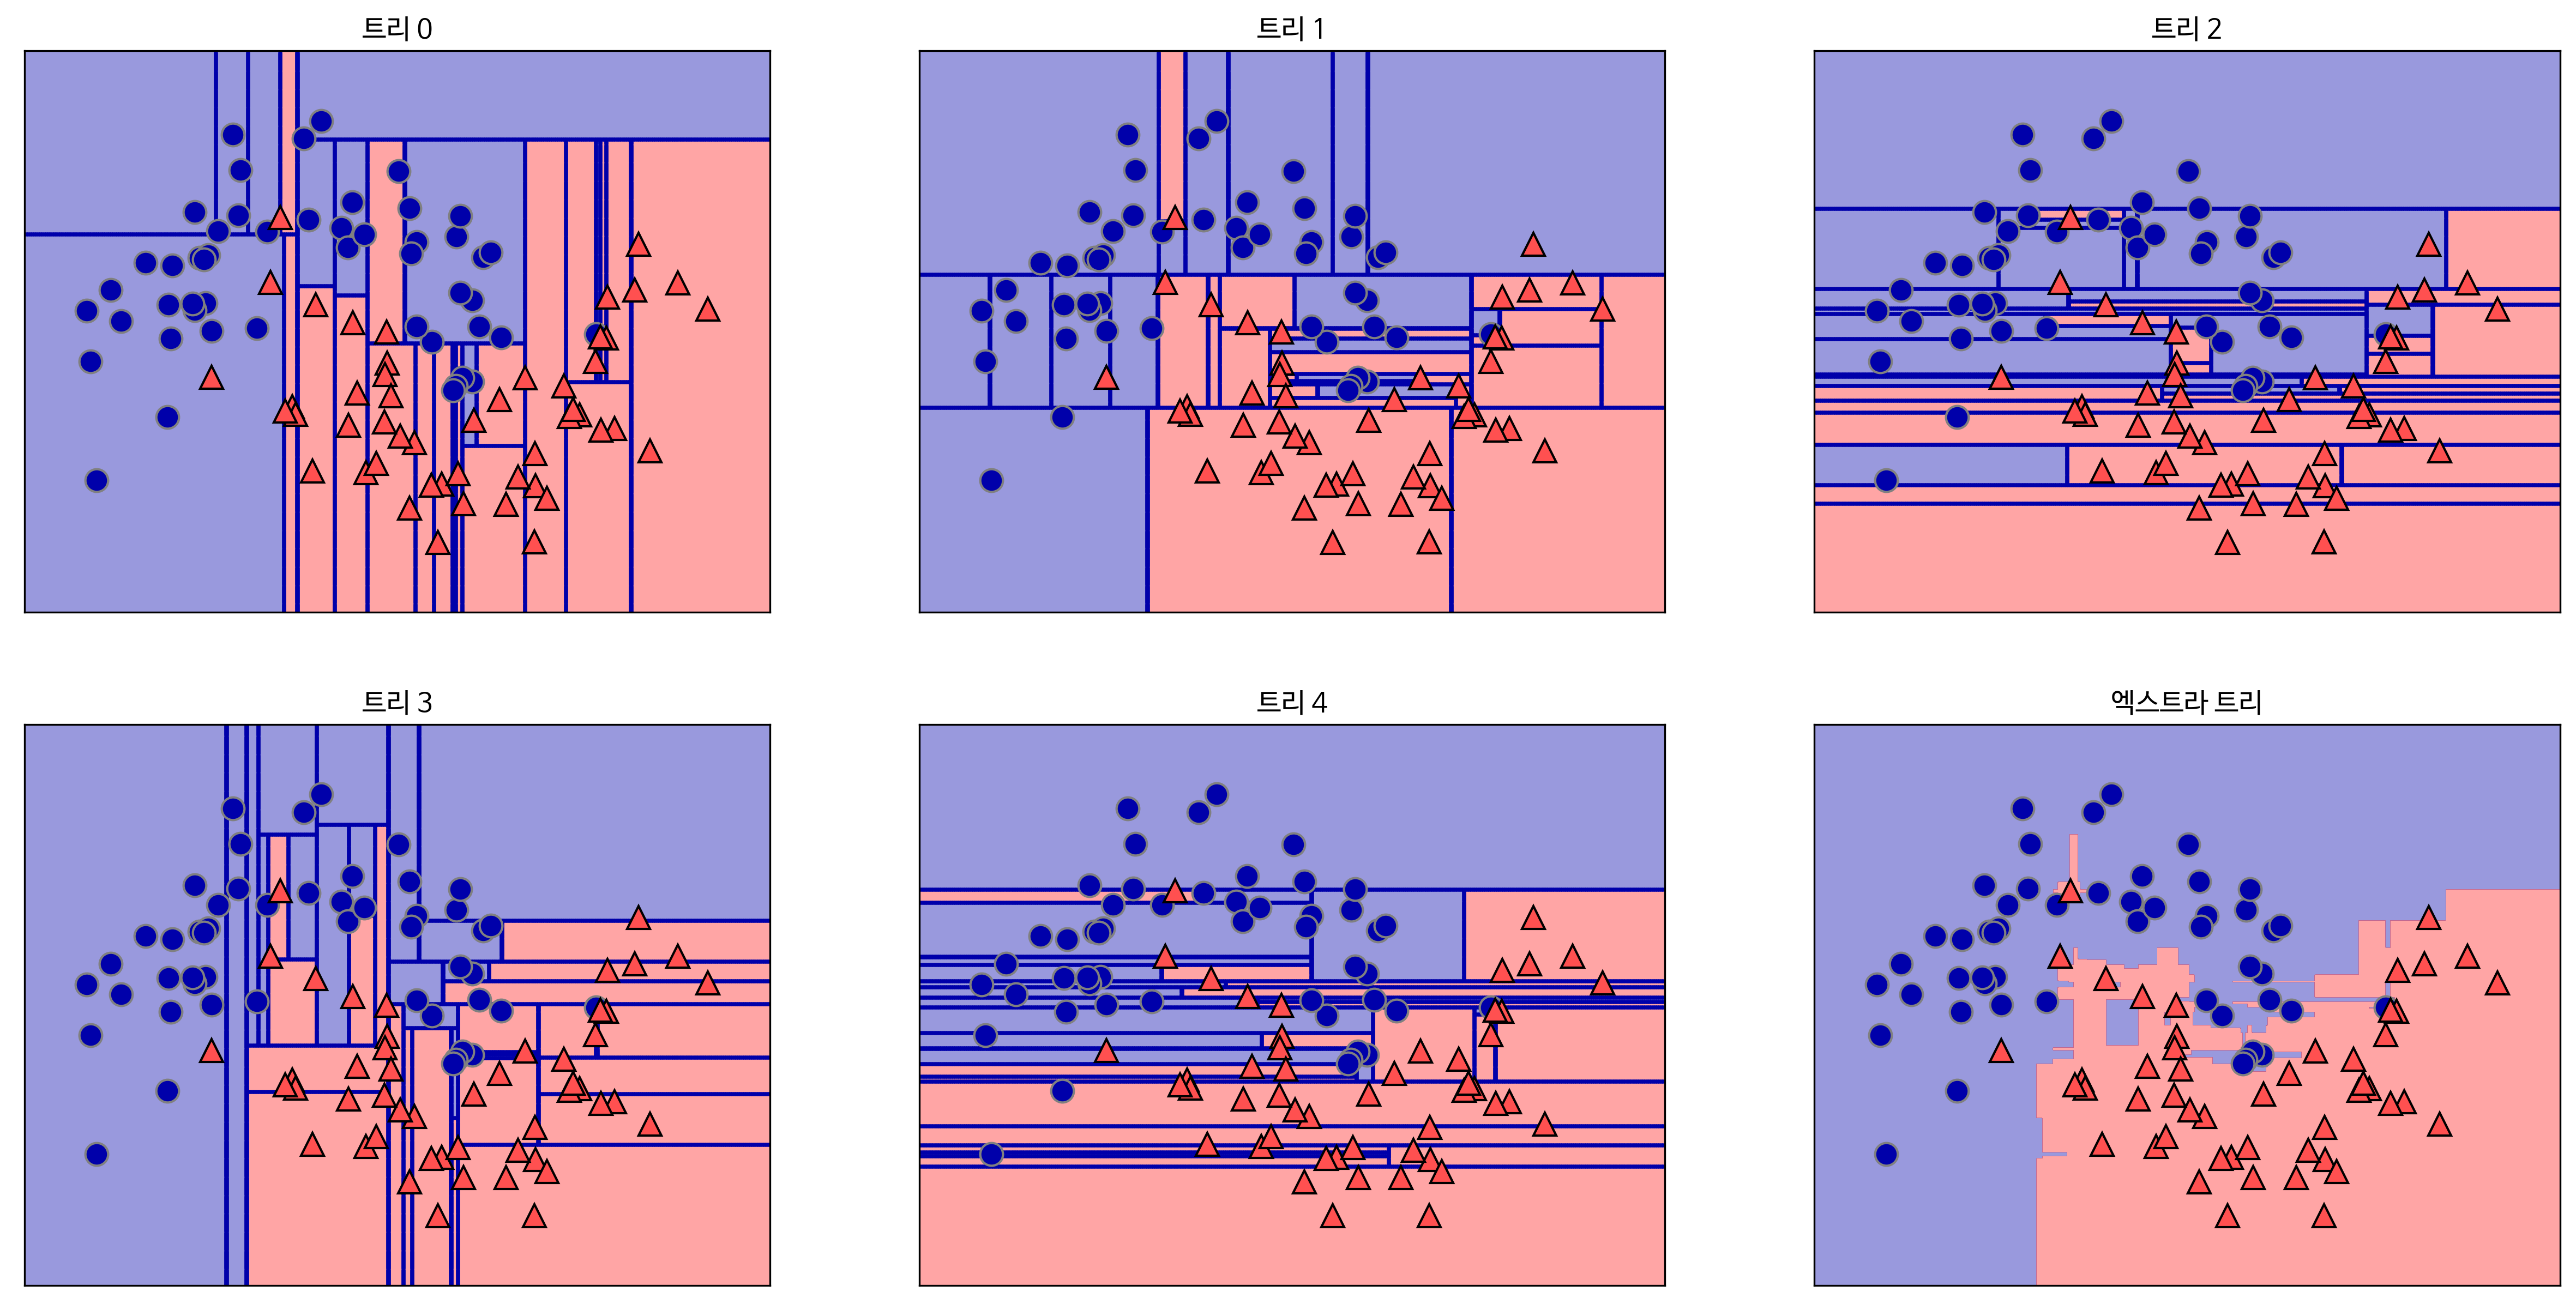

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), xtree.estimators_)):
    ax.set_title("트리 {}".format(i))
    mglearn.plots.plot_tree_partition(Xm, ym, tree, ax=ax)

mglearn.plots.plot_2d_separator(xtree, Xm, fill=True, ax=axes[-1, -1], alpha=.4)
axes[-1, -1].set_title("엑스트라 트리")
mglearn.discrete_scatter(Xm[:, 0], Xm[:, 1], ym)
plt.show()

* ExtraTreesClassifier 트리 개수를 100으로 지정하여 cancer 데이터셋을 적용해보겠습니다.

In [21]:
xtree = ExtraTreesClassifier(n_estimators=100, n_jobs=-1, random_state=0)
xtree.fit(Xc_train, yc_train)
print("훈련 세트 정확도: {:.3f}".format(xtree.score(Xc_train, yc_train)))
print("테스트 세트 정확도: {:.3f}".format(xtree.score(Xc_test, yc_test)))

훈련 세트 정확도: 1.000
테스트 세트 정확도: 0.972


* 엑스트라 트리의 특성 중요도를 시각화해보겠습니다. 엑스트라 트리의 특성 중요도는 비교적 랜덤 포레스트와 비슷합니다.

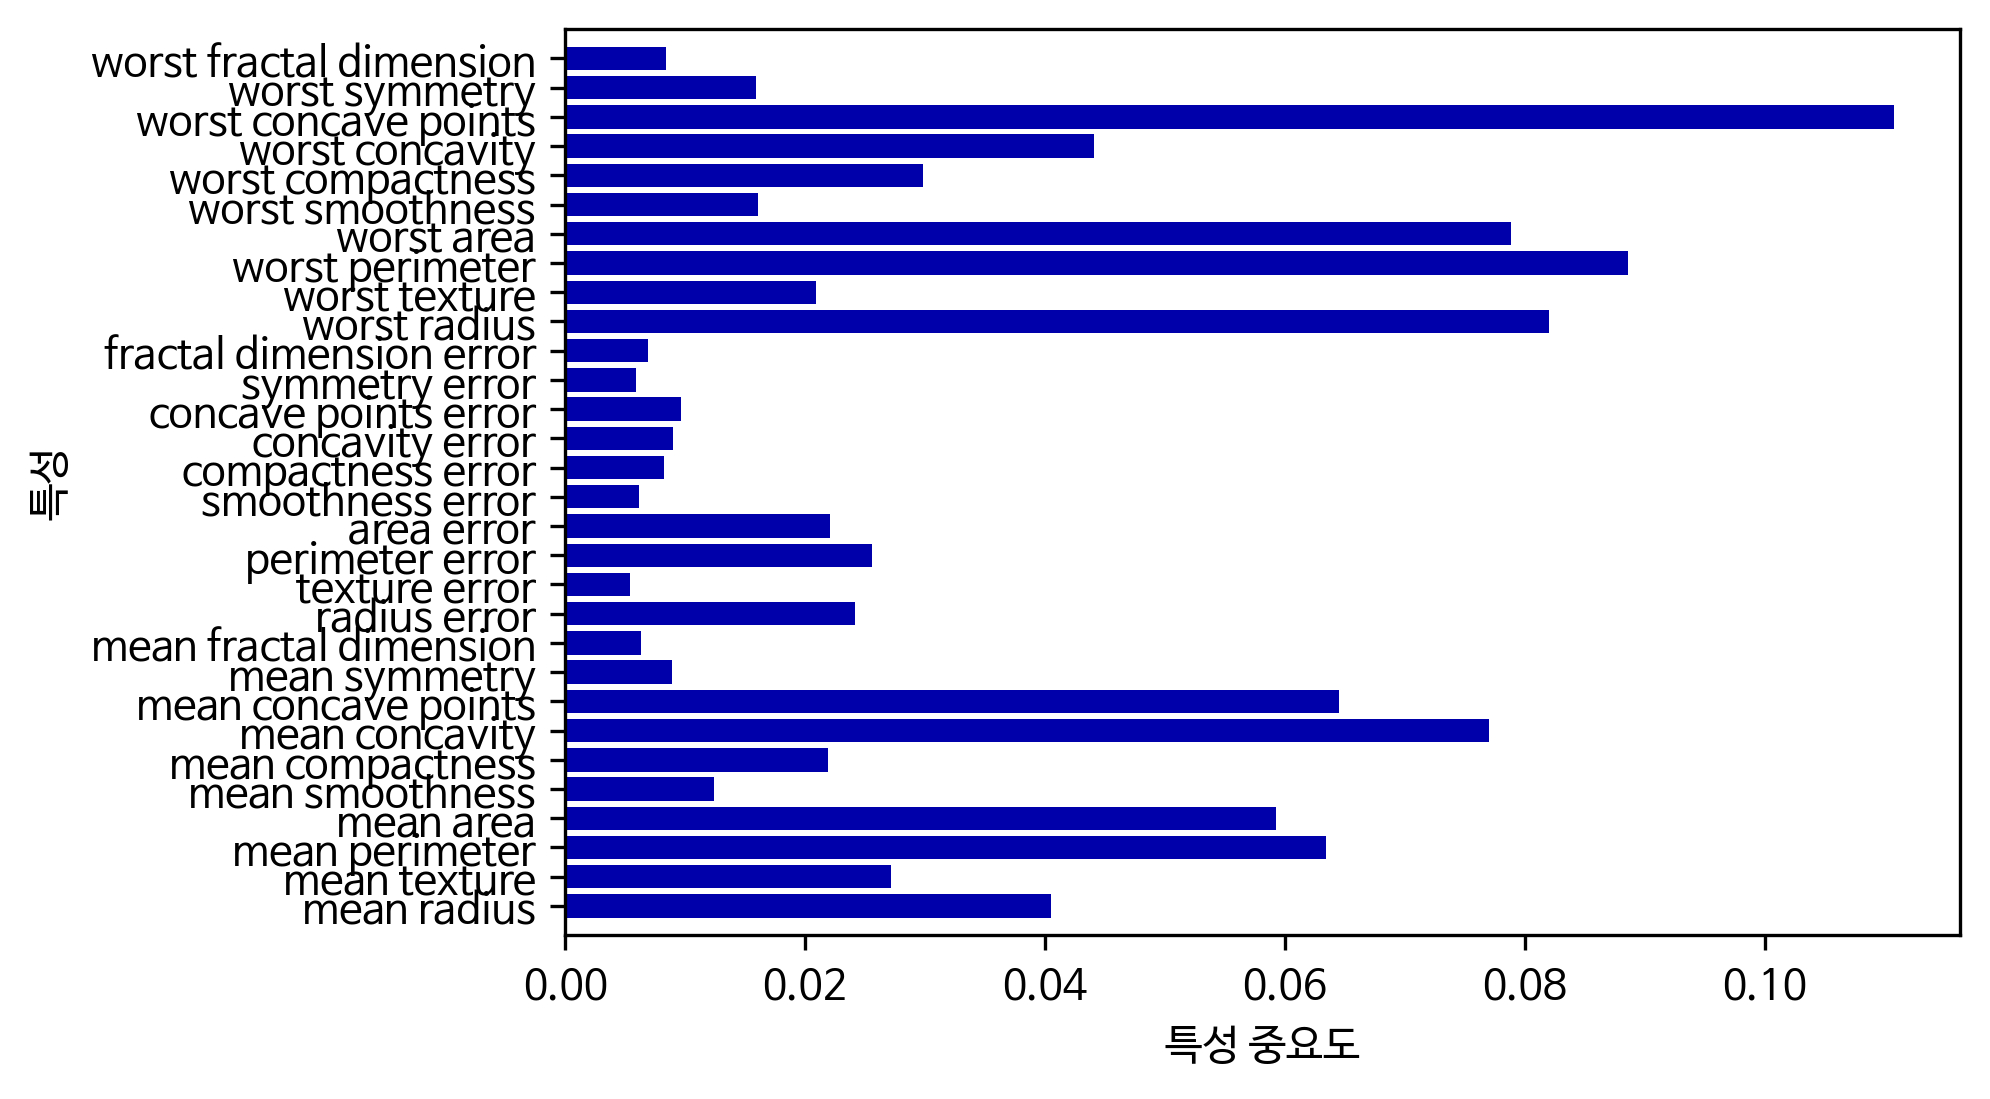

In [22]:
n_features = cancer.data.shape[1]
plt.barh(range(n_features), xtree.feature_importances_, align='center')
plt.yticks(np.arange(n_features), cancer.feature_names)
plt.xlabel("특성 중요도")
plt.ylabel("특성")
plt.ylim(-1, n_features)
plt.show()

### 에이다부스트(AdaBoost)
* 여기에서는 기본값을 사용하여 two_moons 데이터셋과 cancer 데이터셋에 에이다부스트를 적용해 보겠습니다.

In [23]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=5, random_state=42)
ada.fit(Xm_train, ym_train)

AdaBoostClassifier(n_estimators=5, random_state=42)

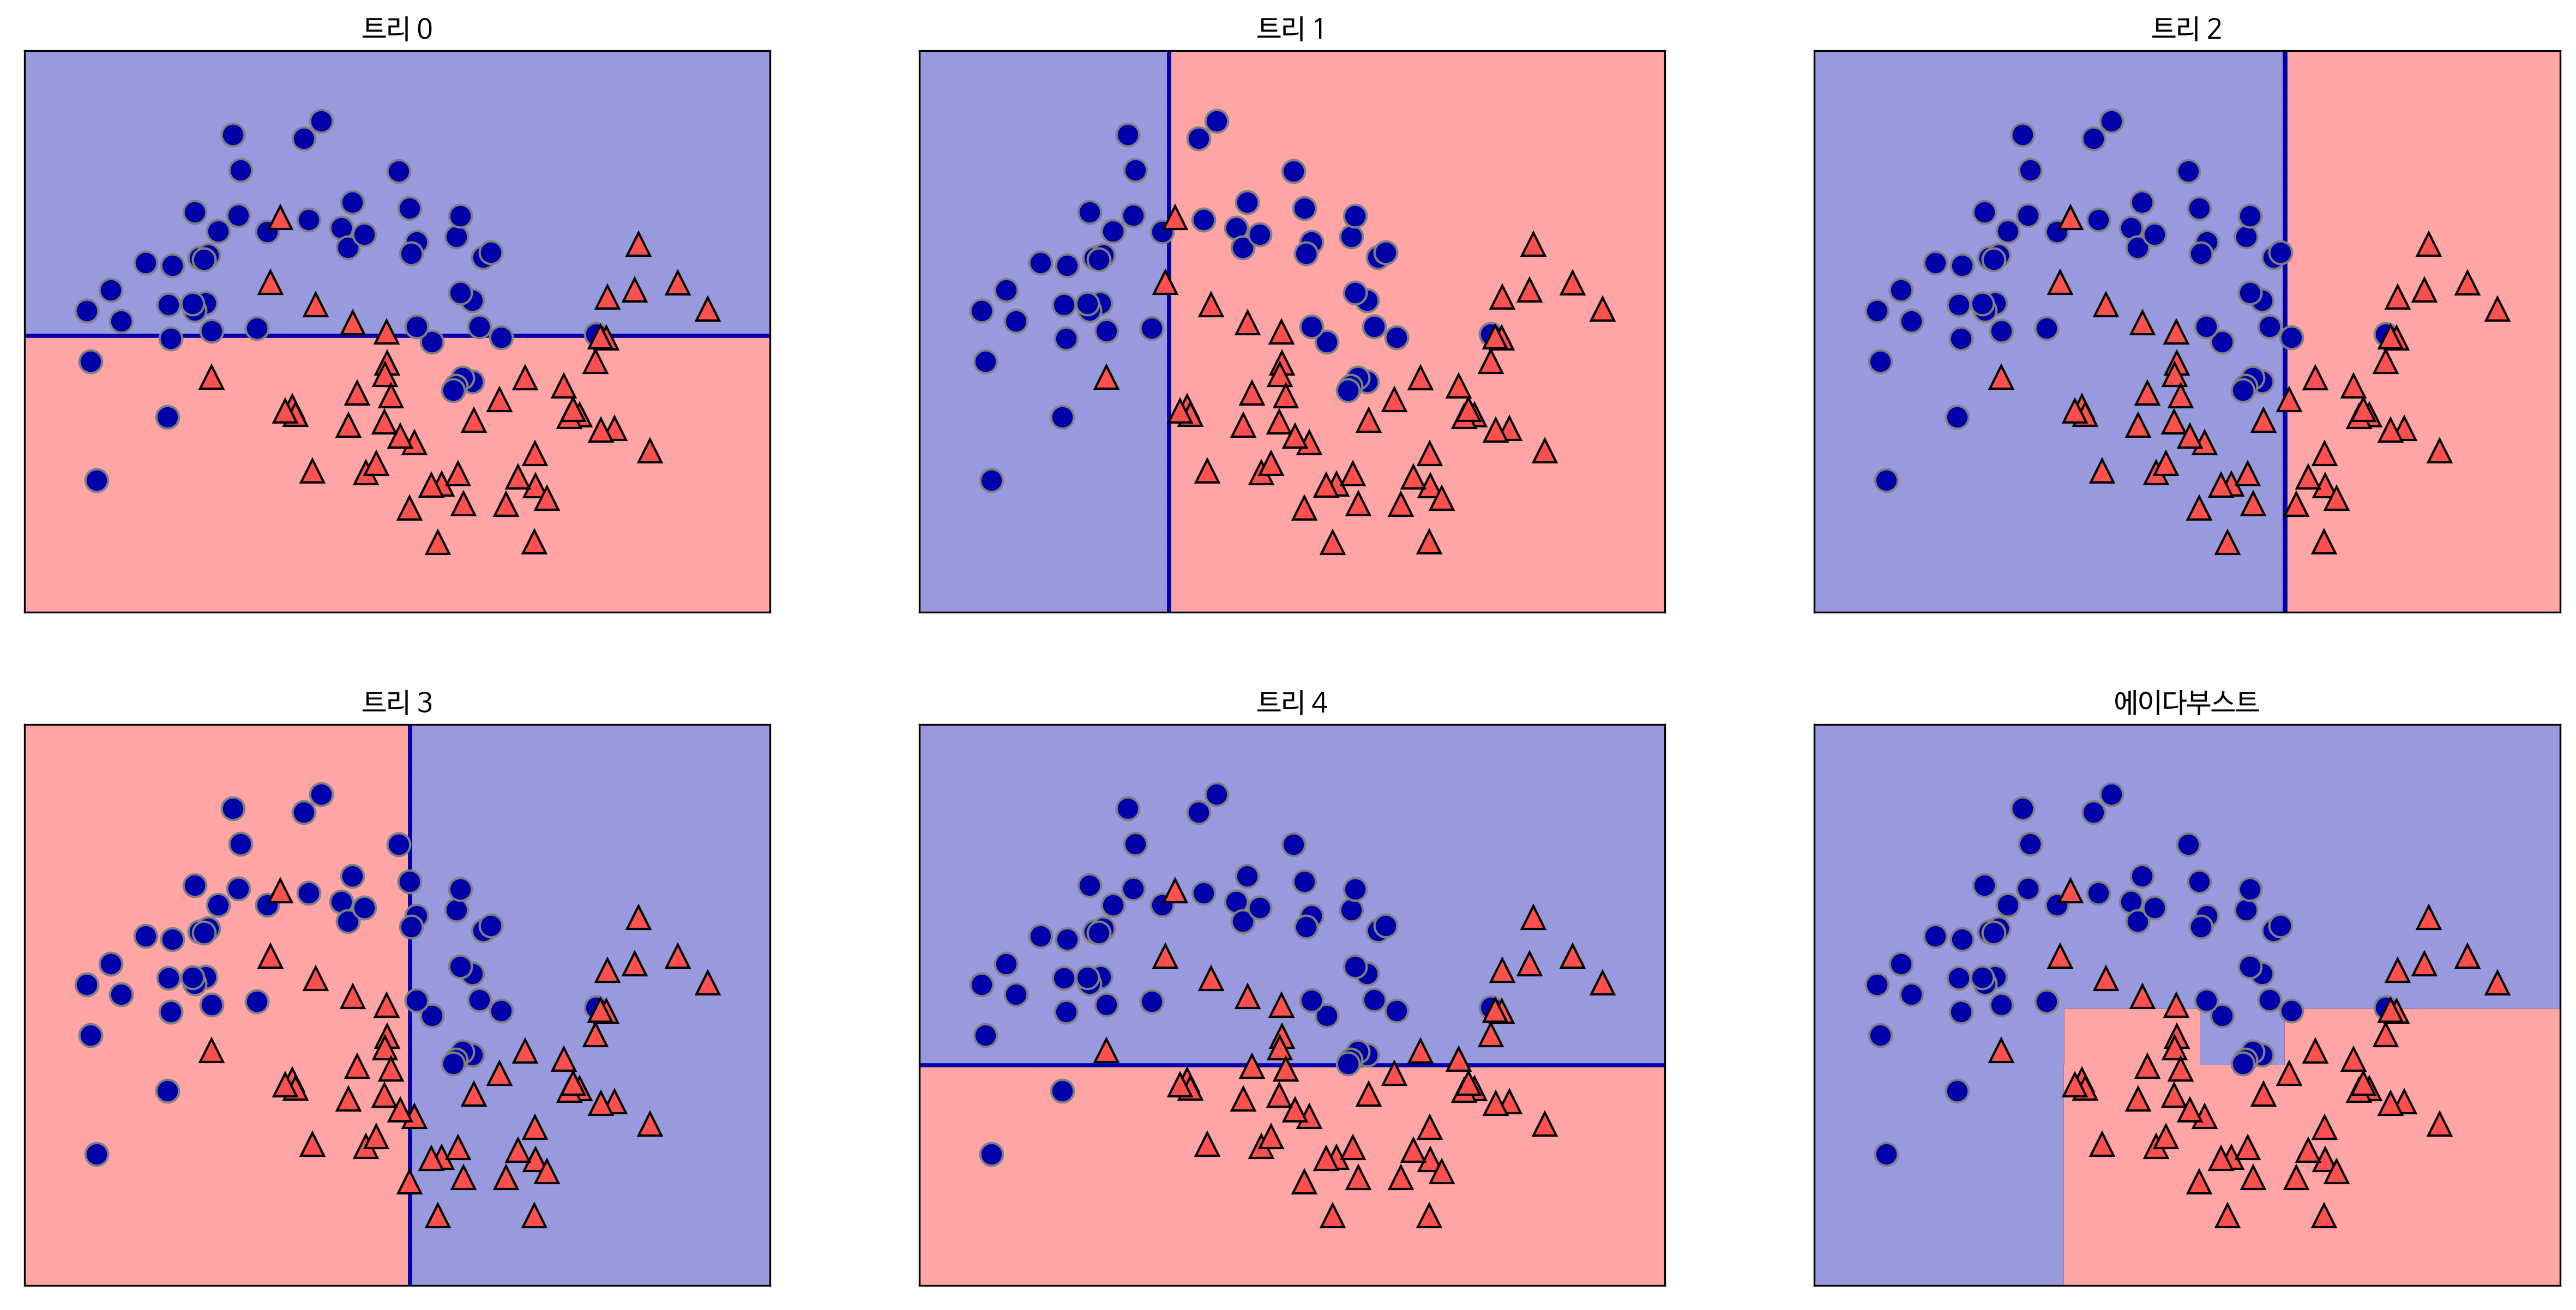

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), ada.estimators_)):
    ax.set_title("트리 {}".format(i))
    mglearn.plots.plot_tree_partition(Xm, ym, tree, ax=ax)
    
mglearn.plots.plot_2d_separator(ada, Xm ,fill=True, ax=axes[-1, -1], alpha=.4)
axes[-1, -1].set_title("에이다부스트")
mglearn.discrete_scatter(Xm[:, 0], Xm[:, 1], ym)
plt.show()

* AdaBoostClassifier는 깊이가 1인 결정 트리를 사용하기 때문에 각 트리의 결정 경계가 직선 하나입니다. 앙상블된 결정 경계도 다른 앙상블 모델에 비해 좀 더 단순합니다. 이번에는 cancer 데이터셋에 적용해보겠습니다.

In [25]:
ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(Xc_train, yc_train)

AdaBoostClassifier(n_estimators=100, random_state=42)

In [26]:
print("훈련 세트 정확도: {:.3f}".format(ada.score(Xc_train, yc_train)))
print("테스트 세트 정확도: {:.3f}".format(ada.score(Xc_test, yc_test)))

훈련 세트 정확도: 1.000
테스트 세트 정확도: 0.986


* 에이다부스트의 특성 중요도를 확인해보면 다른 모델에서 부각되지 않았던 'area error' 특성을 크게 강조하고 있습니다.

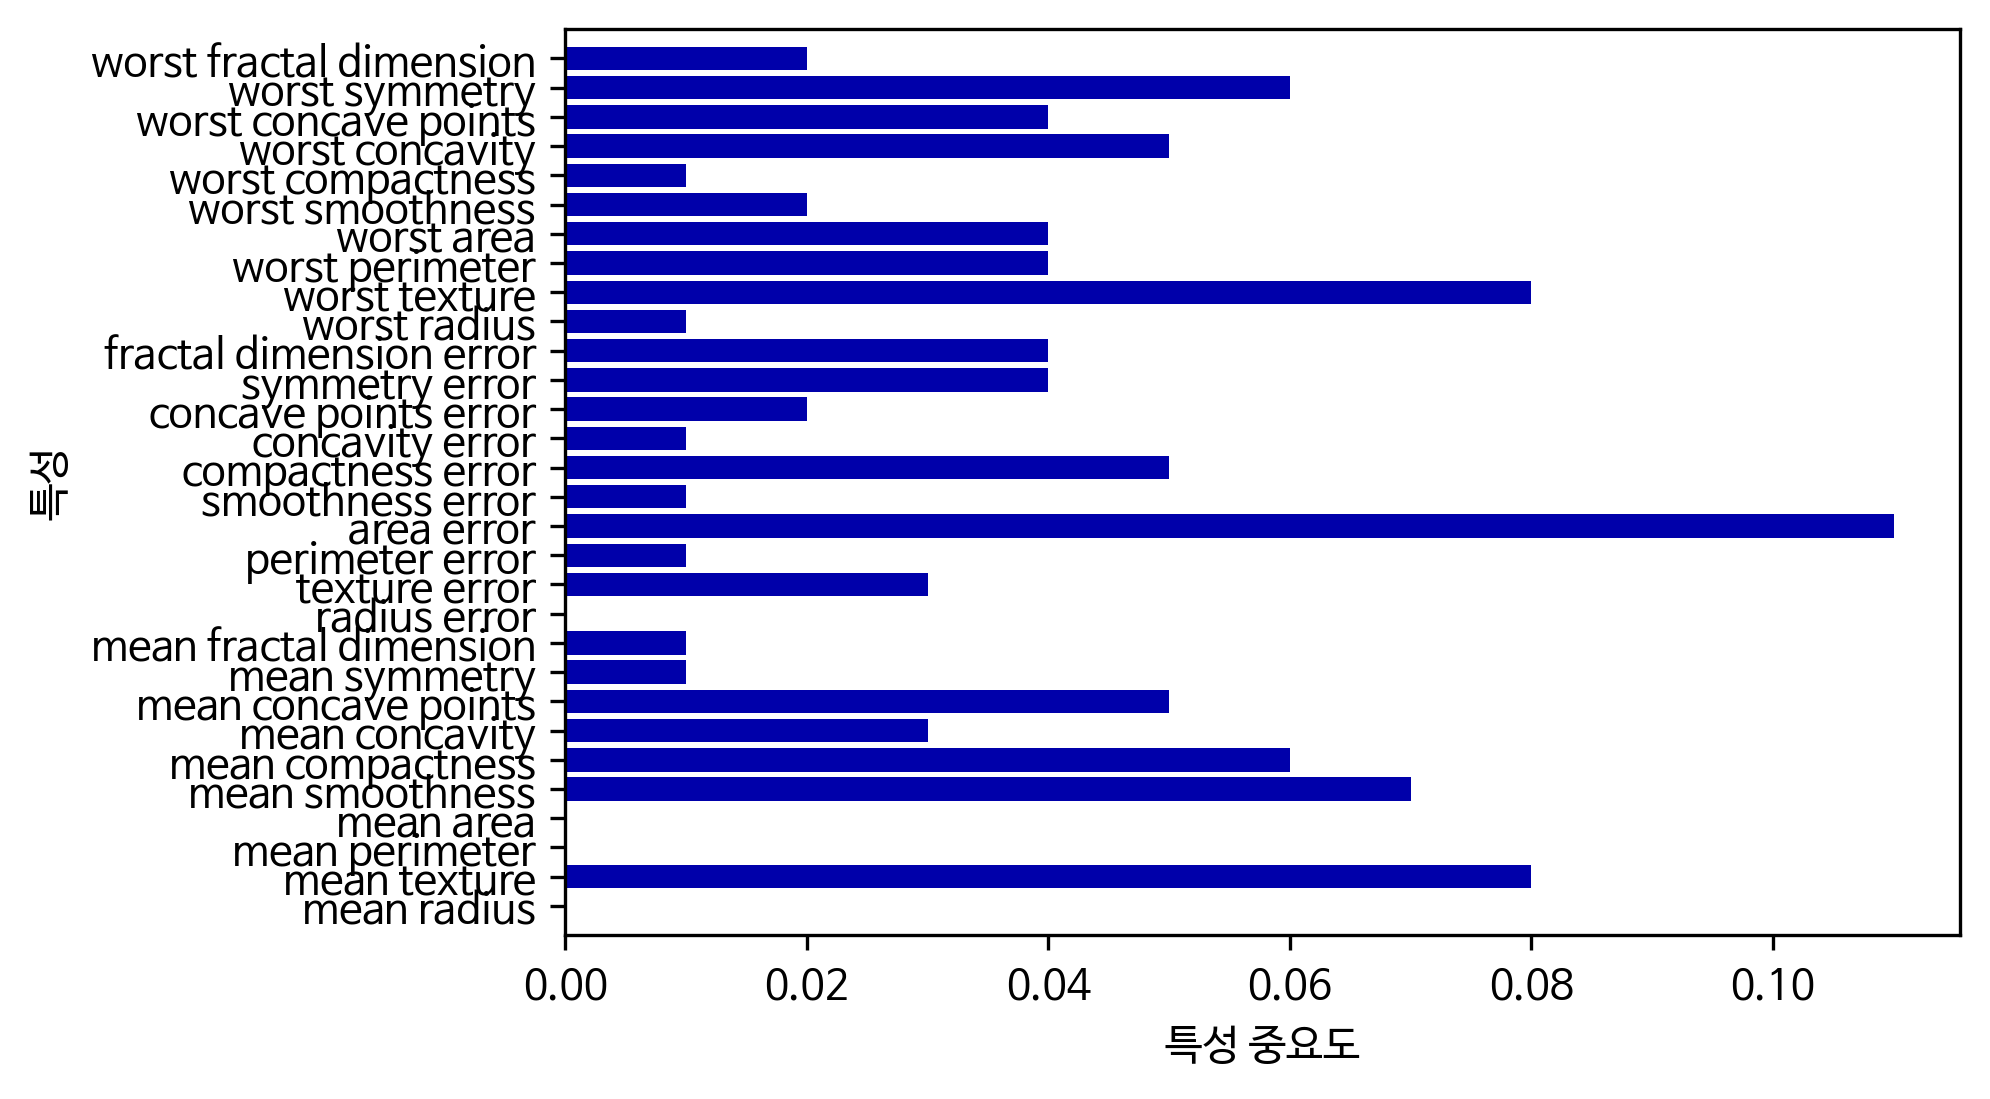

In [28]:
plt.barh(range(n_features), ada.feature_importances_, align='center')
plt.yticks(np.arange(n_features), cancer.feature_names)
plt.xlabel("특성 중요도")
plt.ylabel("특성")
plt.ylim(-1, n_features)
plt.show()